# Furniture classification

## Transfer-learning approach

In this approach we use a pre-trained model in order to achieve better results in less time and resources. This approach is commonly known as transfer learning.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import utilities.training as training
import utilities.visuals as visuals
import utilities.data as data

Using TensorFlow backend.


# Reading the dataset

There are three datasets available varying in size. The amount of classes of each label are balanced regardless the size of the dataset.

Please, check README for links to download the datasets. Unzip them into `datasets` directory.

In [4]:
!cat README.TXT

Furniture Classification
------------------------

Below you find links to download the datasets used in this project.
Download and unzip them into `datasets` directory.

1000 images:
https://s3-sa-east-1.amazonaws.com/tm-capstone/dataset_1000.zip

2500 images:
https://s3-sa-east-1.amazonaws.com/tm-capstone/dataset_2500.zip

5000 images:
https://s3-sa-east-1.amazonaws.com/tm-capstone/dataset_5000.zip



In [5]:
!ls datasets

dataset_1000


In [6]:
image_dataset = data.ImageDataset.load('datasets/dataset_1000')

# Generating bottleneck features

In order to train the classifier, we have to extract the features from images first. These features are commonly known as bottleneck features. This part of the notebook aims to extract these features and also saving them to disk to reuse later.

In [7]:
def create_model_resnet():
    from keras.applications.resnet50 import ResNet50
    from keras.models import Input
    
    input_shape = (224, 224, 3)
    input_tensor = Input(shape=input_shape)
    model = ResNet50(weights='imagenet', input_tensor=input_tensor, include_top=False)
    return model

In [8]:
def extract_features(model, img_paths, batch_size=1):
    """This function extracts image features for each image in img_paths using ResNet50 bottleneck layer.
       Returned features is a numpy array with shape (len(img_paths), 2048).
    """
    import numpy as np
    from keras.applications.resnet50 import preprocess_input
    from keras.preprocessing import image
    
    n = len(img_paths)
    img_array = np.zeros((n, 224, 224, 3))
    
    for i, path in enumerate(img_paths):
        img = image.load_img(path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        x = preprocess_input(img)
        img_array[i] = x
    
    X = model.predict(img_array, batch_size=batch_size, verbose=0)
    X = X.reshape((n, 2048))

    for index in range(X.shape[0]):
        img_path = img_paths[index]
        img_vector = X[index]
    return X

In [9]:
def generate_bottleneck_features(img_files, cache_as=None, silent=False):
    """Generate bottleneck features given list of images"""
    import os
    import numpy as np
    import tensorflow as tf
    import keras.backend as K
    from tqdm import tqdm_notebook
    np.warnings.filterwarnings('ignore')
    
    def noop(lst):
        return lst

    process_func = noop
    if not silent:
        process_func = tqdm_notebook

    def get_or_create_features(model, path, save_to_disk=True):
        bottleneck_values = extract_features(model, [path])[0]
        return bottleneck_values
        
    if cache_as and os.path.exists(cache_as):
        x = np.load(cache_as)
    else:
        with tf.Session(config=tf.ConfigProto(log_device_placement=True)) \
            as sess:
            sess.run(tf.global_variables_initializer())
            K.set_session(sess)
            K.set_learning_phase(1)

            model = create_model_resnet()

            x = np.array([
                get_or_create_features(model, file, save_to_disk=False)
                for file in process_func(img_files)])
            if cache_as:
                np.save(cache_as, x)
    return x

Give the bottleneck model a name just to save the file name accordingly of the model's name.

In [10]:
bottleneck_model_name = 'resnet'

Extracting features and save the result to disk at `data/bottleneck_features_{len(dataset)}_{bottleneck_model_name}.npy`. If the file is already available, it will be loaded automatically into `bottleneck_X` variable.

In [11]:
bottleneck_features_file = 'data/bottleneck_features_{}_{}.npy'.format(
    len(image_dataset), bottleneck_model_name
)
bottleneck_features_file

'data/bottleneck_features_1000_resnet.npy'

In [12]:
bottleneck_X =\
    generate_bottleneck_features(img_files=image_dataset.images, cache_as=bottleneck_features_file)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [13]:
bottleneck_X.shape

(1000, 2048)

### Preparing the train, test and and validation datasets

This uses the bottleneck features as input.

Refer to `utilities/training.py`. Basically it uses the `sklearn`, `test_train_model` methods combined to split the data into three datasets, one for training, other for validation and the last one purely for testing.

In [14]:
dataset =\
    training.TrainTestDataset.split(bottleneck_X, image_dataset.as_targets(),
                                    test_size=.1,
                                    valid_size=.25,
                                    random_state=42)

In [15]:
dataset.shape

((650, 2048), (101, 2048), (249, 2048), (650, 5), (101, 5), (249, 5))

# Building the classifier

The classifier model architecture.

In [16]:
def get_model(num_classes, input_shape):
    from keras.layers import Dropout, Dense
    from keras.models import Sequential, Input
    from keras import regularizers
    from keras import initializers
    import keras.backend as K
    K.set_learning_phase(1)

    classifier = Sequential()
    
    classifier.add(Dense(128, input_shape=input_shape, activation='relu',
                         kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev=0.01, seed=None)))
    
    classifier.add(Dropout(.3))
    
    classifier.add(Dense(num_classes, activation='softmax',
                         kernel_regularizer=regularizers.l2(0.01),
                         activity_regularizer=regularizers.l1(0.01)))
    return classifier

In [ ]:
classifier =\
    get_model(image_dataset.classes, input_shape=bottleneck_X.shape[1:])

In [ ]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 262,917.0
Trainable params: 262,917.0
Non-trainable params: 0.0
_________________________________________________________________


## Training

Once the model is trained, the weights of the best model are saved at `weights.best.{model_name}.hdf5`.

In [20]:
model_name = 'resnet'

In [21]:
trainer = training.Trainer(model_name, classifier)

In [22]:
trained_model =\
    trainer.train(dataset, epochs=100, batch_size=16, verbose=0, verbose_checkpointer=0);

Training history plot

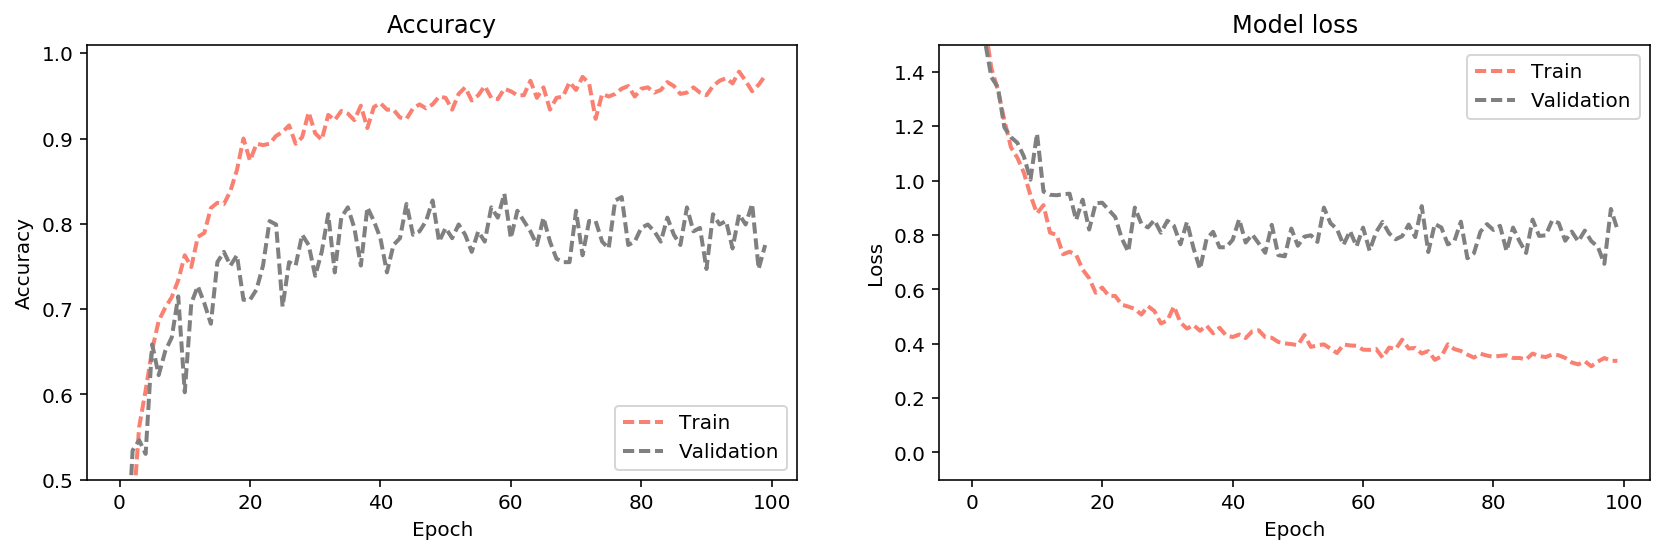

In [23]:
visuals.TrainPlotter(trained_model).plot_history(ylim1=(0.5, 1.01), ylim2=(-0.1, 1.5))

# Evaluation

In [24]:
class_names = ['cup', 'desk', 'pillow', 'mug', 'table lamp']

### Testing

In [25]:
print('Test accuracy: %.4f%%' % trained_model.test(dataset.X_test,
                                                   dataset.y_test))

Test accuracy: 83.1683%


### Softmax predictions

In [26]:
def _display_image_predictions(images, predictions):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    n_classes = 5
    fig, axies = plt.subplots(figsize=(12, 8), nrows=len(images), ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=16, y=1.1)

    n_predictions = 5
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (image_path, pred) in \
        enumerate(zip(images, predictions)):
        
        label_id = np.argmax(pred)
        label_name = class_names[label_id]
        
        pred_names = [class_names[pred_i] for pred_i, _ in enumerate(pred)]
        img = cv2.imread(image_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axies[image_i][0].imshow(img)
        axies[image_i][0].set_title(label_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred, width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(class_names)
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [27]:
def _predict(X, name, model):
    import numpy as np
    import tensorflow as tf
    with tf.Session() as sess:
        model.load_weights('weights.best.{}.hdf5'.format(name))
        
        y_pred = np.array([
            model.predict(np.expand_dims(feature, axis=0))[0]
            for feature in X
        ])
    return y_pred

In [28]:
def random_predict_and_display(n):
    import random
    import numpy as np
    indexes = random.sample(range(len(image_dataset)), n)
    predictions = _predict(bottleneck_X[indexes], model_name, classifier)
    _display_image_predictions(
        np.array(image_dataset.images)[indexes], predictions
    )

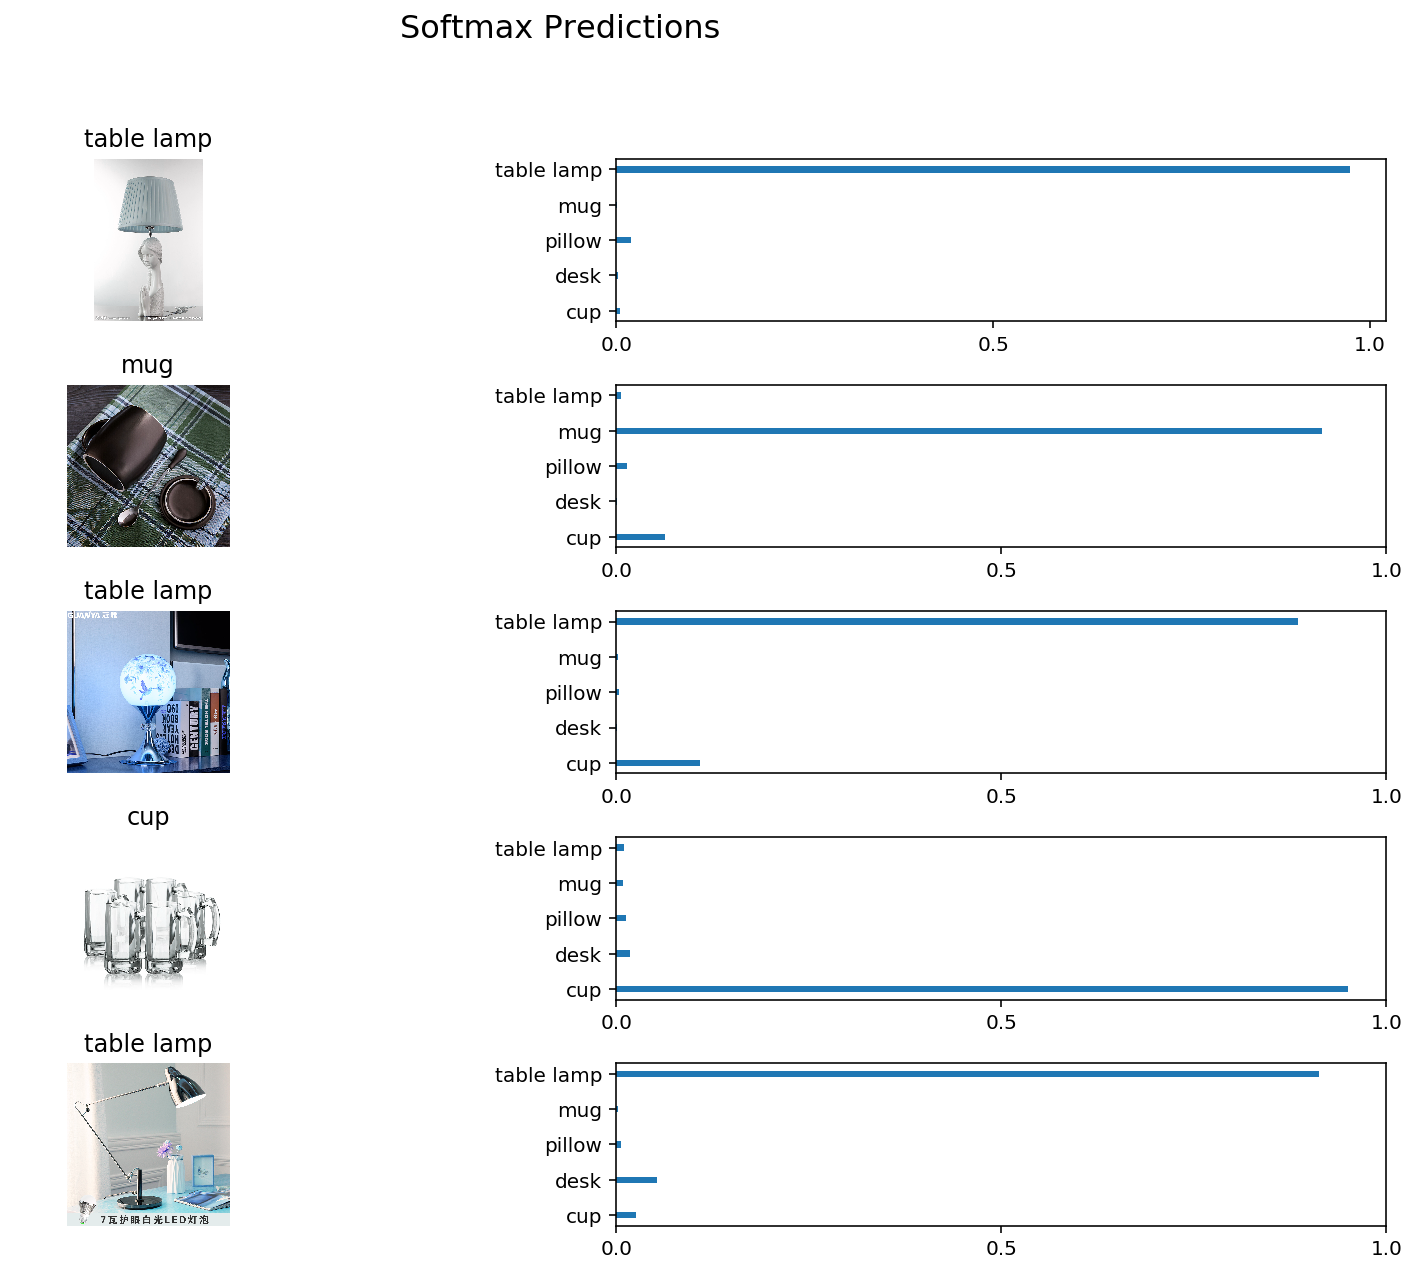

In [29]:
random_predict_and_display(5)

### Confusion matrix

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix

In [31]:
y_pred = trained_model.predict(dataset.X_test)
y_true = np.argmax(dataset.y_test, axis=1)

In [32]:
cnf_matrix = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
[[18  1  3  3  2]
 [ 0  9  0  0  1]
 [ 1  1 28  1  1]
 [ 1  0  0 13  0]
 [ 0  1  0  1 16]]


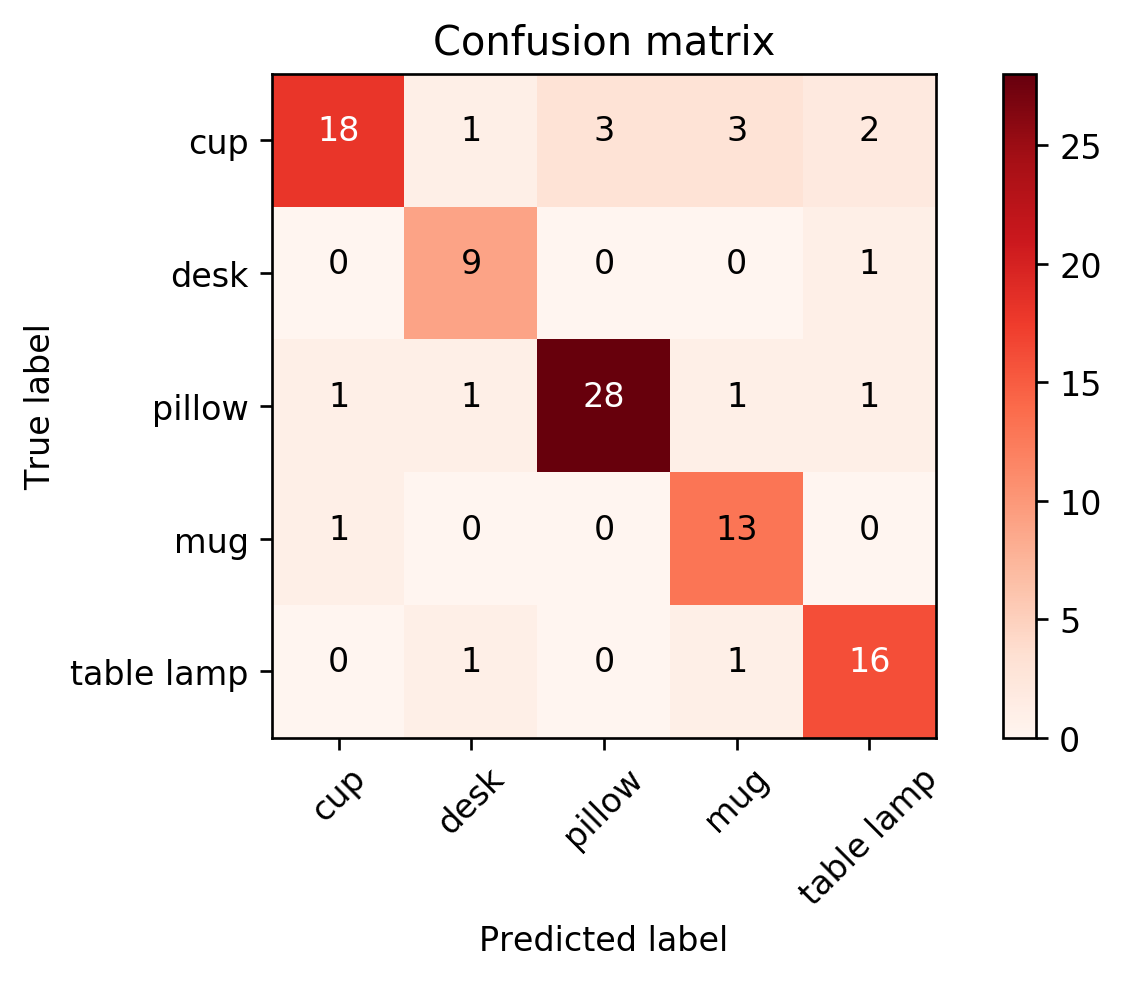

In [33]:
visuals.plot_confusion_matrix(cnf_matrix, classes=class_names, title="Confusion matrix")

Normalized confusion matrix
[[0.66666667 0.03703704 0.11111111 0.11111111 0.07407407]
 [0.         0.9        0.         0.         0.1       ]
 [0.03125    0.03125    0.875      0.03125    0.03125   ]
 [0.07142857 0.         0.         0.92857143 0.        ]
 [0.         0.05555556 0.         0.05555556 0.88888889]]


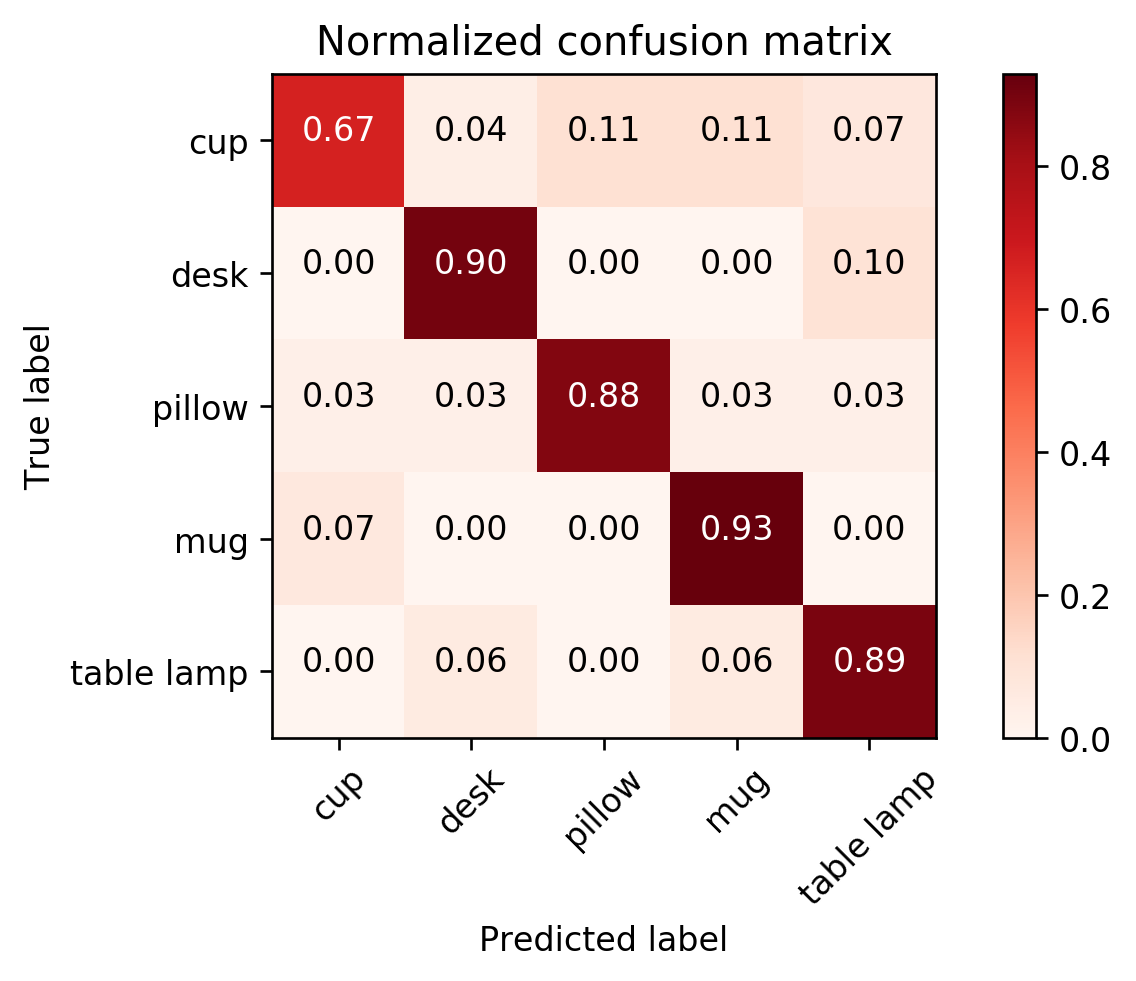

In [34]:
visuals.plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                              title="Normalized confusion matrix")

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.90      0.67      0.77        27
          1       0.75      0.90      0.82        10
          2       0.90      0.88      0.89        32
          3       0.72      0.93      0.81        14
          4       0.80      0.89      0.84        18

avg / total       0.84      0.83      0.83       101

